# Final Scenario Confusion Matrices

`testfinal4feautrenocheat.ipynb`의 마지막 `run_best_model_and_report` 로직을 기준으로
시나리오 A/B/C/C-NS의 `Train/Valid/Test` Confusion Matrix를 출력합니다.

In [1]:
import koreanize_matplotlib
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
)
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier

import warnings
warnings.filterwarnings('ignore')

plt.rcParams['figure.figsize'] = (14, 10)
plt.rcParams['axes.unicode_minus'] = False

In [2]:
# 1) 데이터 로드 (노트와 동일)
df = pd.read_csv('/Users/cheng80/Desktop/diabetes_python/Data/당뇨.csv')
y = df['당뇨']

# 생리학적 오류값 0 -> NaN (마지막 셀 로직 동일)
cols_zero = ['혈당', '혈압', '피부두께', '인슐린', 'BMI']
df[cols_zero] = df[cols_zero].replace(0, np.nan)

print('shape:', df.shape)
print('target ratio:')
print(y.value_counts(normalize=True).rename('ratio'))

shape: (768, 9)
target ratio:
당뇨
0    0.651042
1    0.348958
Name: ratio, dtype: float64


In [3]:
def preprocess_like_final_cell(X_train, X_valid, X_test, is_categorical=False):
    """마지막 run_best_model_and_report 셀 전처리 재현"""
    if not is_categorical:
        # IQR clipping (train 기준)
        for col in X_train.columns:
            q1, q3 = X_train[col].quantile([0.25, 0.75])
            iqr = q3 - q1
            low, up = q1 - 1.5 * iqr, q3 + 1.5 * iqr
            X_train[col] = X_train[col].clip(low, up)
            X_valid[col] = X_valid[col].clip(low, up)
            X_test[col] = X_test[col].clip(low, up)

        scaler = StandardScaler()
        imputer = KNNImputer(n_neighbors=5)
        X_train_pre = imputer.fit_transform(scaler.fit_transform(X_train))
        X_valid_pre = imputer.transform(scaler.transform(X_valid))
        X_test_pre = imputer.transform(scaler.transform(X_test))
    else:
        # 분위수 기반 등급화 (train 기준)
        for col in X_train.columns:
            q1, q2, q3 = X_train[col].quantile([0.25, 0.5, 0.75])

            def to_grade(v):
                if v <= q1:
                    return 1
                elif v <= q2:
                    return 2
                elif v <= q3:
                    return 3
                else:
                    return 4

            X_train[col] = X_train[col].apply(to_grade)
            X_valid[col] = X_valid[col].apply(to_grade)
            X_test[col] = X_test[col].apply(to_grade)

        X_train_pre, X_valid_pre, X_test_pre = X_train, X_valid, X_test

    return X_train_pre, X_valid_pre, X_test_pre


def run_best_model_with_cm(features, scenario_name, is_categorical=False):
    X = df[features].copy()

    # 3-way split (final cell 동일)
    X_temp, X_test, y_temp, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=42
    )
    X_train, X_valid, y_train, y_valid = train_test_split(
        X_temp, y_temp, test_size=0.25, stratify=y_temp, random_state=42
    )

    X_train_pre, X_valid_pre, X_test_pre = preprocess_like_final_cell(
        X_train.copy(), X_valid.copy(), X_test.copy(), is_categorical=is_categorical
    )

    candidate_models = [
        ('LR', LogisticRegression(C=0.01, random_state=42, max_iter=1000)),
        ('KNN', KNeighborsClassifier(n_neighbors=15)),
        ('RF', RandomForestClassifier(n_estimators=100, max_depth=3, random_state=42)),
        ('GB', GradientBoostingClassifier(n_estimators=30, max_depth=2, random_state=42)),
        ('Ada', AdaBoostClassifier(n_estimators=100, learning_rate=0.1, random_state=42)),
        ('SVM', SVC(C=1, probability=True, random_state=42)),
        ('MLP', MLPClassifier(hidden_layer_sizes=(50,), max_iter=1000, random_state=42)),
        ('DT', DecisionTreeClassifier(max_depth=3, random_state=42)),
    ]

    # 1) 단일 모델 학습 + valid score
    model_performance = []
    for name, model in candidate_models:
        model.fit(X_train_pre, y_train)
        val_acc = model.score(X_valid_pre, y_valid)
        model_performance.append({'name': name, 'model': model, 'score': val_acc})

    # 2) top3 앙상블
    model_performance.sort(key=lambda x: x['score'], reverse=True)
    top3 = model_performance[:3]
    ensemble_model = VotingClassifier(
        estimators=[(m['name'], m['model']) for m in top3],
        voting='soft',
    )
    ensemble_model.fit(X_train_pre, y_train)
    ens_score = ensemble_model.score(X_valid_pre, y_valid)
    model_performance.append({'name': 'Voting Ensemble (Top 3 Mix)', 'model': ensemble_model, 'score': ens_score})

    # 3) 최종 winner
    model_performance.sort(key=lambda x: x['score'], reverse=True)
    winner = model_performance[0]
    final_model = winner['model']
    final_name = winner['name']

    # 4) threshold 최적화 (valid accuracy 기준)
    valid_probs = final_model.predict_proba(X_valid_pre)[:, 1]
    best_th, best_acc = 0.5, 0.0
    for th in np.arange(0.3, 0.7, 0.01):
        preds = (valid_probs >= th).astype(int)
        acc = accuracy_score(y_valid, preds)
        if acc > best_acc:
            best_acc, best_th = acc, float(th)

    # 5) split별 confusion matrix + metrics
    def eval_split(X_data, y_data):
        probs = final_model.predict_proba(X_data)[:, 1]
        preds = (probs >= best_th).astype(int)
        cm = confusion_matrix(y_data, preds)
        return {
            'cm': cm,
            'acc': accuracy_score(y_data, preds),
            'precision': precision_score(y_data, preds, zero_division=0),
            'recall': recall_score(y_data, preds, zero_division=0),
            'f1': f1_score(y_data, preds, zero_division=0),
        }

    train_eval = eval_split(X_train_pre, y_train)
    valid_eval = eval_split(X_valid_pre, y_valid)
    test_eval = eval_split(X_test_pre, y_test)

    # 6) 시각화
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    splits = [
        ('Train', train_eval),
        ('Valid', valid_eval),
        ('Test', test_eval),
    ]

    for ax, (split_name, ev) in zip(axes, splits):
        sns.heatmap(
            ev['cm'],
            annot=True,
            fmt='d',
            cmap='Blues',
            cbar=False,
            ax=ax,
            xticklabels=['Pred 0', 'Pred 1'],
            yticklabels=['True 0', 'True 1'],
        )
        ax.set_title(
            f"{split_name}\nAcc={ev['acc']:.4f}, F1={ev['f1']:.4f}",
            fontsize=10,
        )
        ax.set_xlabel('Predicted')
        ax.set_ylabel('Actual')

    plt.suptitle(
        f"{scenario_name}\nWinner={final_name}, threshold={best_th:.2f}",
        fontsize=12,
        y=1.05,
    )
    plt.tight_layout()
    plt.show()

    summary = pd.DataFrame(
        {
            'Train': [train_eval['acc'], train_eval['precision'], train_eval['recall'], train_eval['f1']],
            'Valid': [valid_eval['acc'], valid_eval['precision'], valid_eval['recall'], valid_eval['f1']],
            'Test': [test_eval['acc'], test_eval['precision'], test_eval['recall'], test_eval['f1']],
        },
        index=['Accuracy', 'Precision', 'Recall', 'F1_Score'],
    )

    print(f"[SUMMARY] {scenario_name}")
    print(f"- Winner: {final_name}")
    print(f"- Threshold: {best_th:.2f}")
    display(summary.round(4))

    return {
        'scenario': scenario_name,
        'winner': final_name,
        'threshold': best_th,
        'metrics': summary,
    }

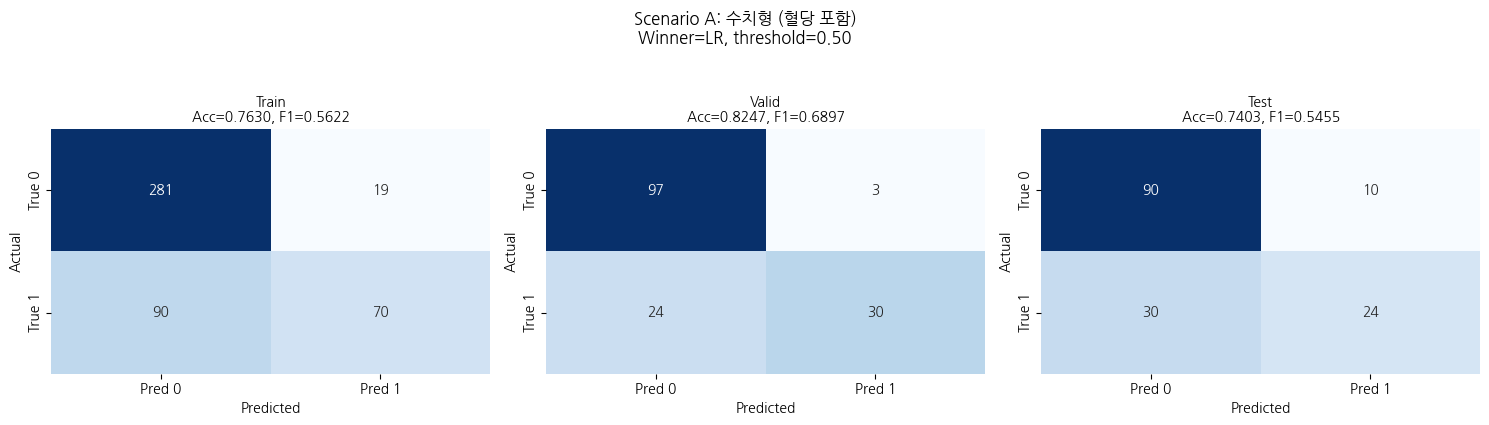

[SUMMARY] Scenario A: 수치형 (혈당 포함)
- Winner: LR
- Threshold: 0.50


,Train,Valid,Test
Accuracy,0.7630,0.8247,0.7403
Precision,0.7865,0.9091,0.7059
Recall,0.4375,0.5556,0.4444
F1_Score,0.5622,0.6897,0.5455


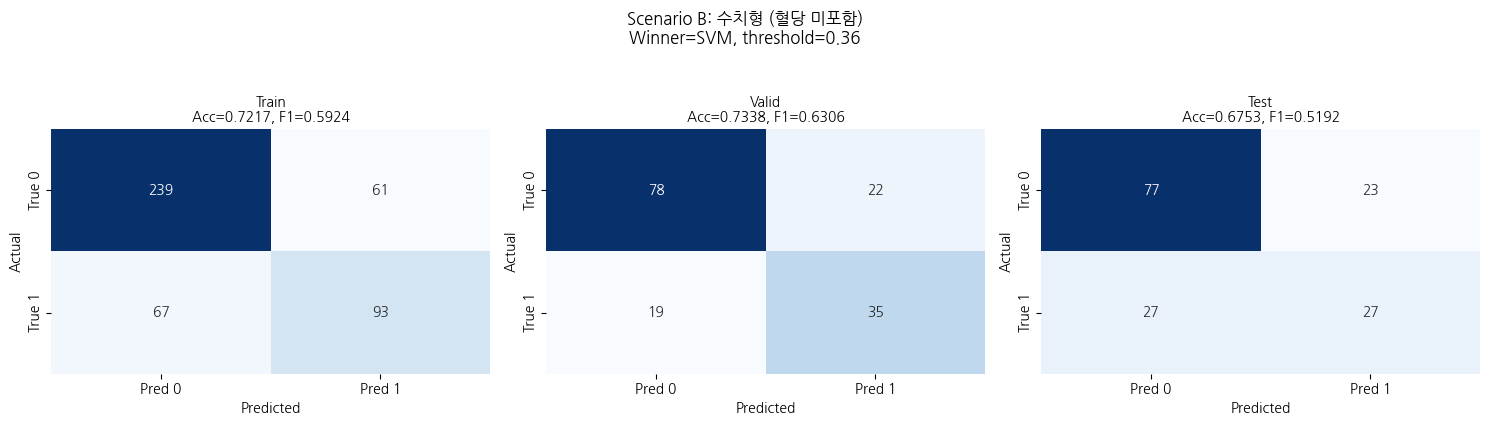

[SUMMARY] Scenario B: 수치형 (혈당 미포함)
- Winner: SVM
- Threshold: 0.36


,Train,Valid,Test
Accuracy,0.7217,0.7338,0.6753
Precision,0.6039,0.6140,0.5400
Recall,0.5812,0.6481,0.5000
F1_Score,0.5924,0.6306,0.5192


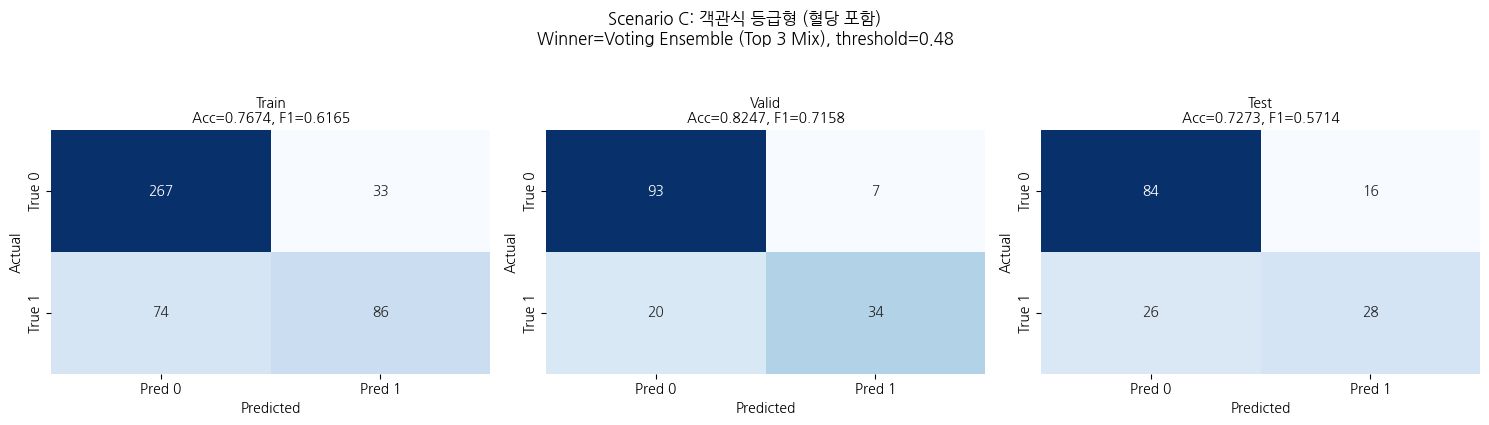

[SUMMARY] Scenario C: 객관식 등급형 (혈당 포함)
- Winner: Voting Ensemble (Top 3 Mix)
- Threshold: 0.48


,Train,Valid,Test
Accuracy,0.7674,0.8247,0.7273
Precision,0.7227,0.8293,0.6364
Recall,0.5375,0.6296,0.5185
F1_Score,0.6165,0.7158,0.5714


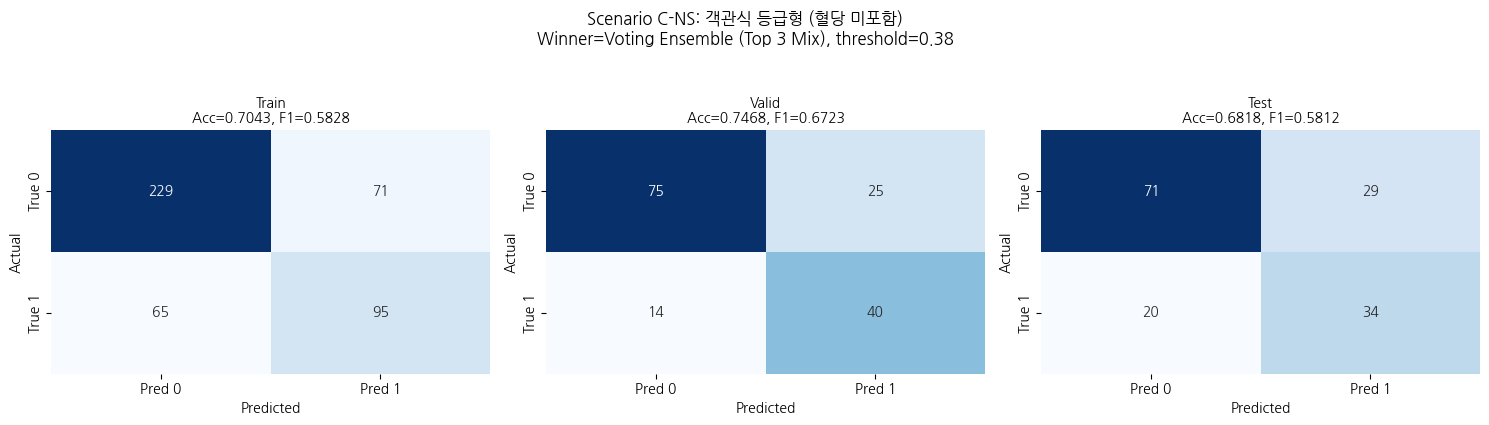

[SUMMARY] Scenario C-NS: 객관식 등급형 (혈당 미포함)
- Winner: Voting Ensemble (Top 3 Mix)
- Threshold: 0.38


,Train,Valid,Test
Accuracy,0.7043,0.7468,0.6818
Precision,0.5723,0.6154,0.5397
Recall,0.5938,0.7407,0.6296
F1_Score,0.5828,0.6723,0.5812


In [4]:
# 3) 시나리오 실행
results = []

results.append(
    run_best_model_with_cm(
        ['임신횟수', '혈당', 'BMI', '나이'],
        'Scenario A: 수치형 (혈당 포함)',
        is_categorical=False,
    )
)

results.append(
    run_best_model_with_cm(
        ['임신횟수', 'BMI', '나이'],
        'Scenario B: 수치형 (혈당 미포함)',
        is_categorical=False,
    )
)

results.append(
    run_best_model_with_cm(
        ['임신횟수', '혈당', 'BMI', '나이'],
        'Scenario C: 객관식 등급형 (혈당 포함)',
        is_categorical=True,
    )
)

results.append(
    run_best_model_with_cm(
        ['임신횟수', 'BMI', '나이'],
        'Scenario C-NS: 객관식 등급형 (혈당 미포함)',
        is_categorical=True,
    )
)

In [5]:
# 4) 시나리오별 winner/threshold/test accuracy 요약
summary_rows = []
for r in results:
    test_acc = r['metrics'].loc['Accuracy', 'Test']
    summary_rows.append(
        {
            'Scenario': r['scenario'],
            'Winner': r['winner'],
            'Threshold': round(r['threshold'], 2),
            'Test Accuracy': round(float(test_acc), 4),
        }
    )

summary_df = pd.DataFrame(summary_rows)
display(summary_df)

,Scenario,Winner,Threshold,Test Accuracy
0,Scenario A: 수치형 (혈당 포함),LR,0.50,0.7403
1,Scenario B: 수치형 (혈당 미포함),SVM,0.36,0.6753
2,Scenario C: 객관식 등급형 (혈당 포함),Voting Ensemble (Top 3 Mix),0.48,0.7273
3,Scenario C-NS: 객관식 등급형 (혈당 미포함),Voting Ensemble (Top 3 Mix),0.38,0.6818


## Optimization Logs Visualization

위쪽 탐색 과정(모델 순위 + 임계값 탐색)을 그래프로 시각화해서,
최종 셀의 모델/threshold 선택 근거를 확인합니다.

In [6]:
def collect_optimization_logs(features, scenario_name, is_categorical=False):
    X = df[features].copy()

    # split (마지막 셀과 동일)
    X_temp, X_test, y_temp, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=42
    )
    X_train, X_valid, y_train, y_valid = train_test_split(
        X_temp, y_temp, test_size=0.25, stratify=y_temp, random_state=42
    )

    X_train_pre, X_valid_pre, X_test_pre = preprocess_like_final_cell(
        X_train.copy(), X_valid.copy(), X_test.copy(), is_categorical=is_categorical
    )

    candidate_models = [
        ('LR', LogisticRegression(C=0.01, random_state=42, max_iter=1000)),
        ('KNN', KNeighborsClassifier(n_neighbors=15)),
        ('RF', RandomForestClassifier(n_estimators=100, max_depth=3, random_state=42)),
        ('GB', GradientBoostingClassifier(n_estimators=30, max_depth=2, random_state=42)),
        ('Ada', AdaBoostClassifier(n_estimators=100, learning_rate=0.1, random_state=42)),
        ('SVM', SVC(C=1, probability=True, random_state=42)),
        ('MLP', MLPClassifier(hidden_layer_sizes=(50,), max_iter=1000, random_state=42)),
        ('DT', DecisionTreeClassifier(max_depth=3, random_state=42)),
    ]

    perf = []
    fitted = {}
    for name, model in candidate_models:
        model.fit(X_train_pre, y_train)
        valid_acc = model.score(X_valid_pre, y_valid)
        perf.append({'Model': name, 'Valid Accuracy': valid_acc})
        fitted[name] = model

    perf_df = pd.DataFrame(perf).sort_values('Valid Accuracy', ascending=False).reset_index(drop=True)

    top3_names = perf_df.head(3)['Model'].tolist()
    ensemble = VotingClassifier(
        estimators=[(n, fitted[n]) for n in top3_names],
        voting='soft',
    )
    ensemble.fit(X_train_pre, y_train)
    ens_acc = ensemble.score(X_valid_pre, y_valid)

    perf_df = pd.concat(
        [
            perf_df,
            pd.DataFrame([{'Model': 'Voting Ensemble (Top 3 Mix)', 'Valid Accuracy': ens_acc}]),
        ],
        ignore_index=True,
    ).sort_values('Valid Accuracy', ascending=False).reset_index(drop=True)

    winner_name = perf_df.iloc[0]['Model']
    winner_model = ensemble if winner_name == 'Voting Ensemble (Top 3 Mix)' else fitted[winner_name]

    # threshold 탐색 로그
    valid_probs = winner_model.predict_proba(X_valid_pre)[:, 1]
    th_records = []
    best_th, best_acc = 0.5, -1.0
    for th in np.arange(0.30, 0.70, 0.01):
        pred = (valid_probs >= th).astype(int)
        acc = accuracy_score(y_valid, pred)
        th_records.append({'threshold': float(th), 'valid_accuracy': float(acc)})
        if acc > best_acc:
            best_acc, best_th = acc, float(th)

    th_df = pd.DataFrame(th_records)

    return {
        'scenario': scenario_name,
        'perf_df': perf_df,
        'th_df': th_df,
        'winner': winner_name,
        'best_th': best_th,
        'best_acc': best_acc,
    }


=== A: 수치형(혈당 포함) ===
Winner: LR | Best threshold: 0.50 | Best valid acc: 0.8247


,Model,Valid Accuracy
0,LR,0.8247
1,Voting Ensemble (Top 3 Mix),0.8052
2,RF,0.7987
3,Ada,0.7922
4,GB,0.7857
5,DT,0.7857
6,SVM,0.7792
7,MLP,0.7727
8,KNN,0.7662


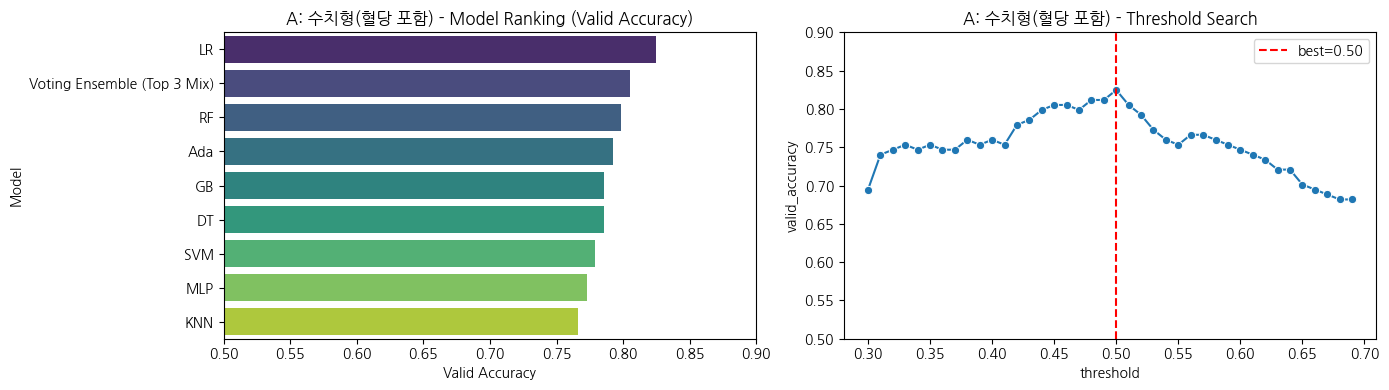


=== B: 수치형(혈당 미포함) ===
Winner: SVM | Best threshold: 0.36 | Best valid acc: 0.7338


,Model,Valid Accuracy
0,SVM,0.7273
1,MLP,0.7273
2,DT,0.7273
3,KNN,0.7143
4,RF,0.7143
5,LR,0.7013
6,GB,0.7013
7,Voting Ensemble (Top 3 Mix),0.6948
8,Ada,0.6364


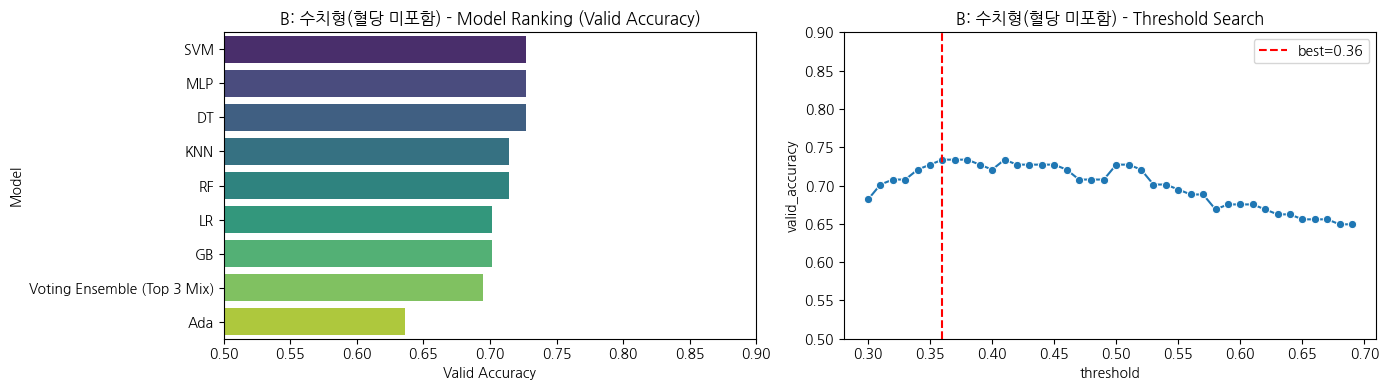


=== C: 객관식(혈당 포함) ===
Winner: Voting Ensemble (Top 3 Mix) | Best threshold: 0.48 | Best valid acc: 0.8247


,Model,Valid Accuracy
0,Voting Ensemble (Top 3 Mix),0.8117
1,Ada,0.8052
2,DT,0.8052
3,RF,0.7987
4,GB,0.7987
5,LR,0.7857
6,KNN,0.7857
7,SVM,0.7662
8,MLP,0.7662


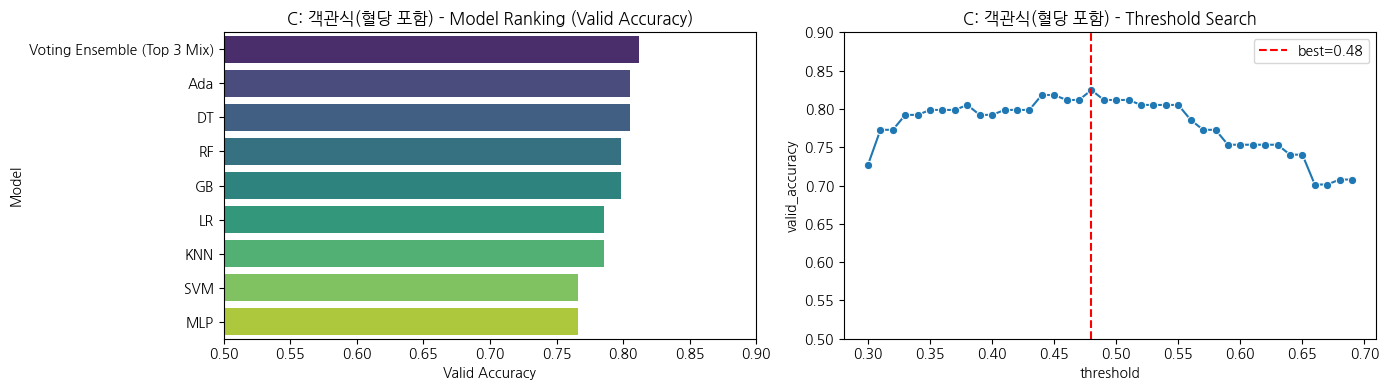


=== C-NS: 객관식(혈당 미포함) ===
Winner: Voting Ensemble (Top 3 Mix) | Best threshold: 0.38 | Best valid acc: 0.7468


,Model,Valid Accuracy
0,Voting Ensemble (Top 3 Mix),0.7403
1,KNN,0.7273
2,Ada,0.7273
3,GB,0.7143
4,SVM,0.7143
5,LR,0.7013
6,MLP,0.7013
7,RF,0.6948
8,DT,0.6948


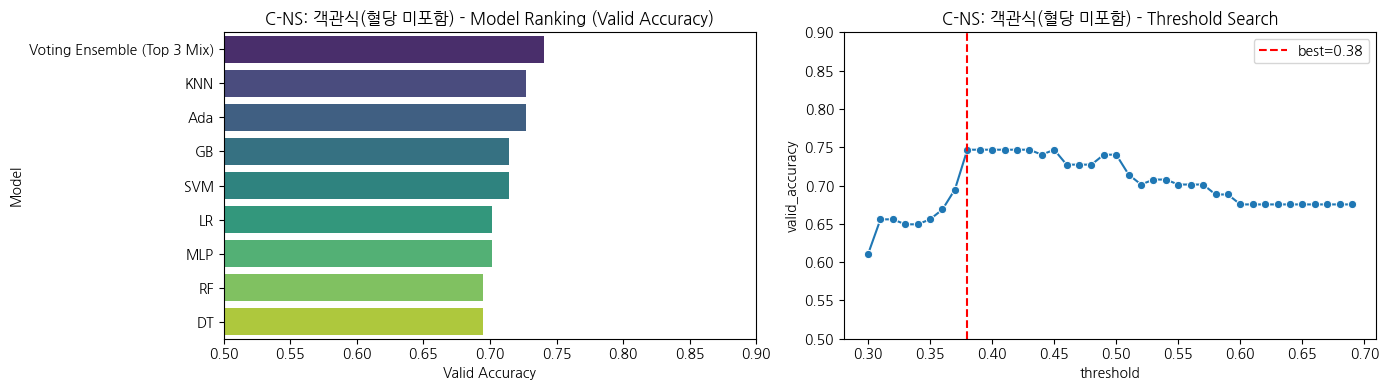

In [7]:
logs = []
logs.append(collect_optimization_logs(['임신횟수', '혈당', 'BMI', '나이'], 'A: 수치형(혈당 포함)', False))
logs.append(collect_optimization_logs(['임신횟수', 'BMI', '나이'], 'B: 수치형(혈당 미포함)', False))
logs.append(collect_optimization_logs(['임신횟수', '혈당', 'BMI', '나이'], 'C: 객관식(혈당 포함)', True))
logs.append(collect_optimization_logs(['임신횟수', 'BMI', '나이'], 'C-NS: 객관식(혈당 미포함)', True))

for item in logs:
    print(f"\n=== {item['scenario']} ===")
    print(f"Winner: {item['winner']} | Best threshold: {item['best_th']:.2f} | Best valid acc: {item['best_acc']:.4f}")
    display(item['perf_df'].round(4))

    fig, axes = plt.subplots(1, 2, figsize=(14, 4))

    # (1) 모델 Valid Accuracy 순위
    sns.barplot(
        data=item['perf_df'],
        x='Valid Accuracy',
        y='Model',
        palette='viridis',
        ax=axes[0],
    )
    axes[0].set_title(f"{item['scenario']} - Model Ranking (Valid Accuracy)")
    axes[0].set_xlim(0.5, 0.9)

    # (2) threshold 탐색 곡선
    sns.lineplot(
        data=item['th_df'],
        x='threshold',
        y='valid_accuracy',
        marker='o',
        ax=axes[1],
    )
    axes[1].axvline(item['best_th'], color='red', linestyle='--', label=f"best={item['best_th']:.2f}")
    axes[1].set_title(f"{item['scenario']} - Threshold Search")
    axes[1].set_ylim(0.5, 0.9)
    axes[1].legend()

    plt.tight_layout()
    plt.show()

## Extra Diagnostics (Top Cells)

최종 선택 근거를 강화하기 위한 추가 그래프:
- 클래스 분포(전체/분할)
- 후보 모델별 Accuracy/Precision/Recall/F1
- Winner 모델의 ROC/PR Curve

In [8]:
from sklearn.metrics import roc_curve, precision_recall_curve, auc, average_precision_score


def collect_extended_logs(features, scenario_name, is_categorical=False):
    X = df[features].copy()

    # split (마지막 셀과 동일)
    X_temp, X_test, y_temp, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=42
    )
    X_train, X_valid, y_train, y_valid = train_test_split(
        X_temp, y_temp, test_size=0.25, stratify=y_temp, random_state=42
    )

    X_train_pre, X_valid_pre, X_test_pre = preprocess_like_final_cell(
        X_train.copy(), X_valid.copy(), X_test.copy(), is_categorical=is_categorical
    )

    candidate_models = [
        ('LR', LogisticRegression(C=0.01, random_state=42, max_iter=1000)),
        ('KNN', KNeighborsClassifier(n_neighbors=15)),
        ('RF', RandomForestClassifier(n_estimators=100, max_depth=3, random_state=42)),
        ('GB', GradientBoostingClassifier(n_estimators=30, max_depth=2, random_state=42)),
        ('Ada', AdaBoostClassifier(n_estimators=100, learning_rate=0.1, random_state=42)),
        ('SVM', SVC(C=1, probability=True, random_state=42)),
        ('MLP', MLPClassifier(hidden_layer_sizes=(50,), max_iter=1000, random_state=42)),
        ('DT', DecisionTreeClassifier(max_depth=3, random_state=42)),
    ]

    model_perf = []
    fitted = {}

    for name, model in candidate_models:
        model.fit(X_train_pre, y_train)
        probs = model.predict_proba(X_valid_pre)[:, 1]
        preds = (probs >= 0.5).astype(int)

        model_perf.append({
            'Model': name,
            'Accuracy': accuracy_score(y_valid, preds),
            'Precision': precision_score(y_valid, preds, zero_division=0),
            'Recall': recall_score(y_valid, preds, zero_division=0),
            'F1_Score': f1_score(y_valid, preds, zero_division=0),
            'Valid Score(model.score)': model.score(X_valid_pre, y_valid),
        })
        fitted[name] = model

    perf_df = pd.DataFrame(model_perf).sort_values('Accuracy', ascending=False).reset_index(drop=True)

    # top3 ensemble (valid score 기준)
    top3 = perf_df.sort_values('Valid Score(model.score)', ascending=False).head(3)['Model'].tolist()
    ensemble = VotingClassifier(
        estimators=[(n, fitted[n]) for n in top3],
        voting='soft',
    )
    ensemble.fit(X_train_pre, y_train)
    ens_probs = ensemble.predict_proba(X_valid_pre)[:, 1]
    ens_preds = (ens_probs >= 0.5).astype(int)

    perf_df = pd.concat(
        [
            perf_df,
            pd.DataFrame([{
                'Model': 'Voting Ensemble (Top 3 Mix)',
                'Accuracy': accuracy_score(y_valid, ens_preds),
                'Precision': precision_score(y_valid, ens_preds, zero_division=0),
                'Recall': recall_score(y_valid, ens_preds, zero_division=0),
                'F1_Score': f1_score(y_valid, ens_preds, zero_division=0),
                'Valid Score(model.score)': ensemble.score(X_valid_pre, y_valid),
            }])
        ],
        ignore_index=True
    ).sort_values('Accuracy', ascending=False).reset_index(drop=True)

    winner_name = perf_df.iloc[0]['Model']
    winner_model = ensemble if winner_name == 'Voting Ensemble (Top 3 Mix)' else fitted[winner_name]

    # threshold search
    valid_probs = winner_model.predict_proba(X_valid_pre)[:, 1]
    th_rows = []
    best_th, best_acc = 0.5, -1.0
    for th in np.arange(0.30, 0.70, 0.01):
        preds = (valid_probs >= th).astype(int)
        acc = accuracy_score(y_valid, preds)
        th_rows.append({'threshold': float(th), 'valid_accuracy': float(acc)})
        if acc > best_acc:
            best_acc = acc
            best_th = float(th)

    th_df = pd.DataFrame(th_rows)

    # ROC / PR
    fpr, tpr, _ = roc_curve(y_valid, valid_probs)
    roc_auc = auc(fpr, tpr)

    pr_precision, pr_recall, _ = precision_recall_curve(y_valid, valid_probs)
    ap = average_precision_score(y_valid, valid_probs)

    return {
        'scenario': scenario_name,
        'y_train': y_train,
        'y_valid': y_valid,
        'y_test': y_test,
        'perf_df': perf_df,
        'th_df': th_df,
        'winner': winner_name,
        'best_th': best_th,
        'best_acc': best_acc,
        'fpr': fpr,
        'tpr': tpr,
        'roc_auc': roc_auc,
        'pr_precision': pr_precision,
        'pr_recall': pr_recall,
        'ap': ap,
    }

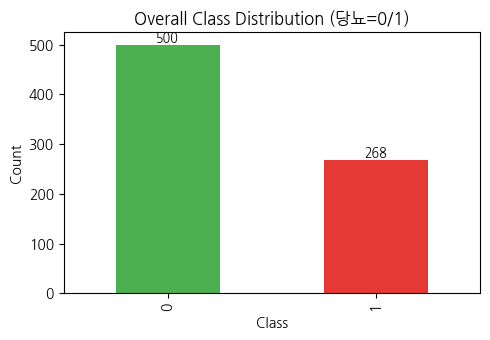


=== A: 수치형(혈당 포함) ===
Winner: LR | Best threshold: 0.50 | Best valid acc: 0.8247


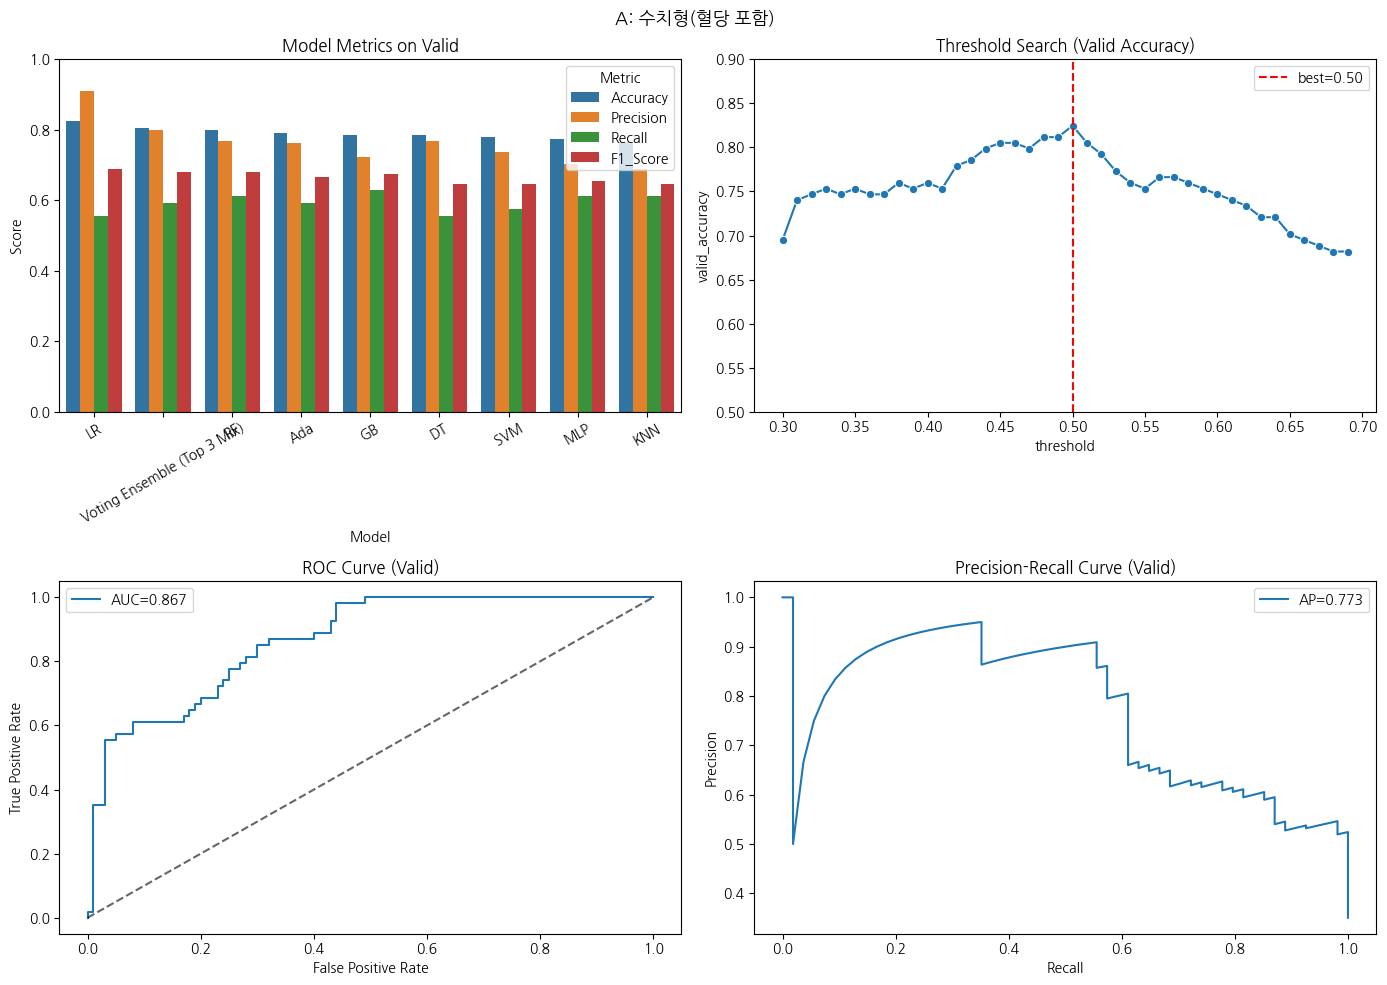

,Model,Accuracy,Precision,Recall,F1_Score,Valid Score(model.score)
0,LR,0.8247,0.9091,0.5556,0.6897,0.8247
1,Voting Ensemble (Top 3 Mix),0.8052,0.8000,0.5926,0.6809,0.8052
2,RF,0.7987,0.7674,0.6111,0.6804,0.7987
3,Ada,0.7922,0.7619,0.5926,0.6667,0.7922
4,GB,0.7857,0.7234,0.6296,0.6733,0.7857
5,DT,0.7857,0.7692,0.5556,0.6452,0.7857
6,SVM,0.7792,0.7381,0.5741,0.6458,0.7792
7,MLP,0.7727,0.7021,0.6111,0.6535,0.7727
8,KNN,0.7662,0.6875,0.6111,0.6471,0.7662



=== B: 수치형(혈당 미포함) ===
Winner: MLP | Best threshold: 0.42 | Best valid acc: 0.7338


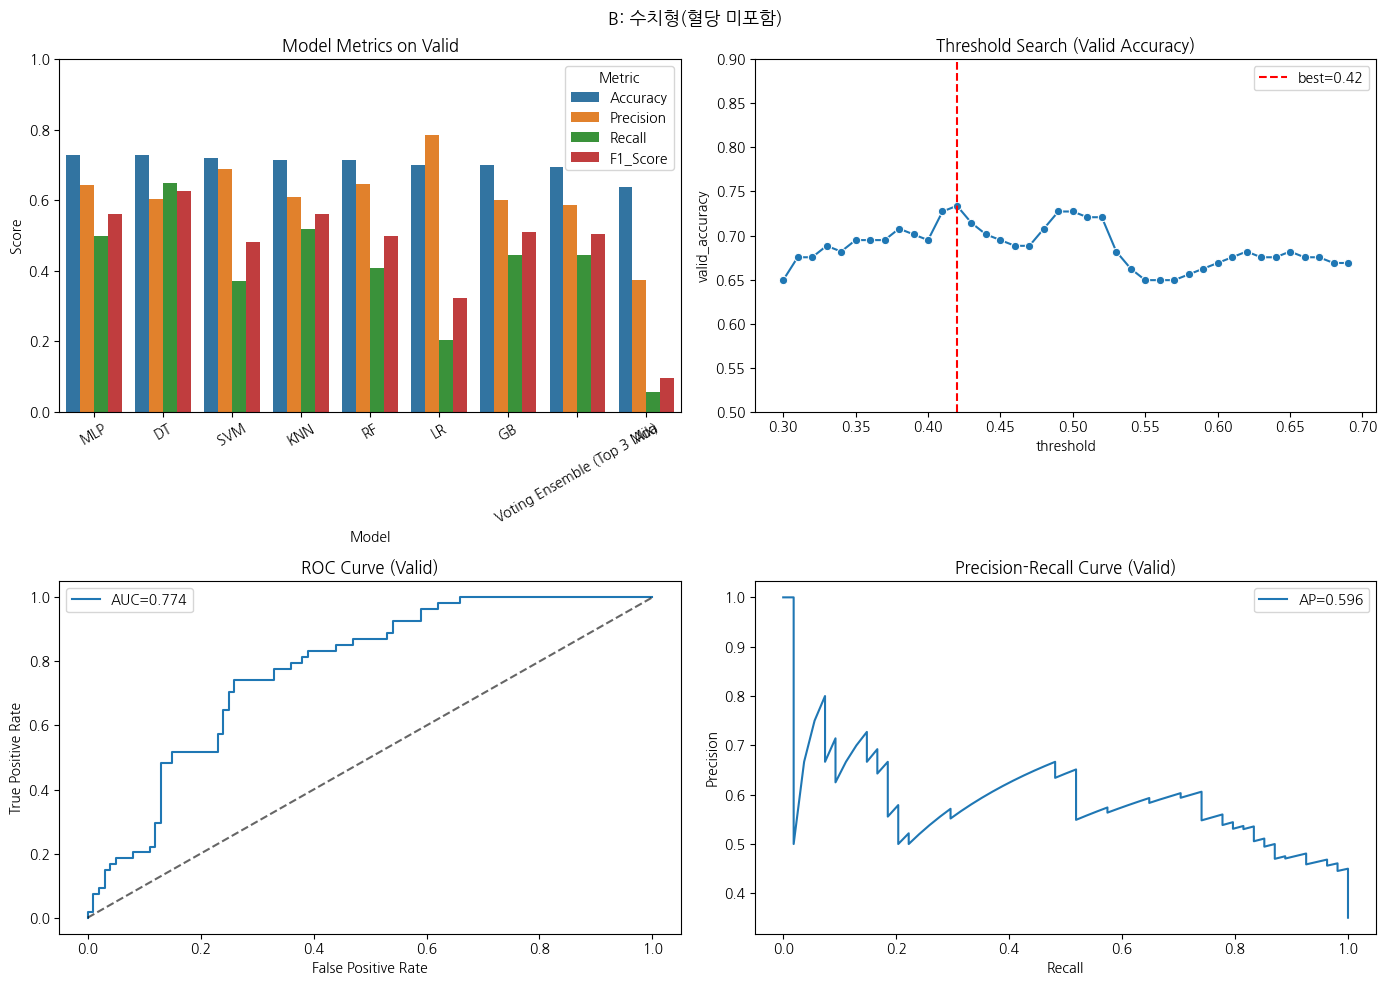

,Model,Accuracy,Precision,Recall,F1_Score,Valid Score(model.score)
0,MLP,0.7273,0.6429,0.5000,0.5625,0.7273
1,DT,0.7273,0.6034,0.6481,0.6250,0.7273
2,SVM,0.7208,0.6897,0.3704,0.4819,0.7273
3,KNN,0.7143,0.6087,0.5185,0.5600,0.7143
4,RF,0.7143,0.6471,0.4074,0.5000,0.7143
5,LR,0.7013,0.7857,0.2037,0.3235,0.7013
6,GB,0.7013,0.6000,0.4444,0.5106,0.7013
7,Voting Ensemble (Top 3 Mix),0.6948,0.5854,0.4444,0.5053,0.6948
8,Ada,0.6364,0.3750,0.0556,0.0968,0.6364



=== C: 객관식(혈당 포함) ===
Winner: Voting Ensemble (Top 3 Mix) | Best threshold: 0.48 | Best valid acc: 0.8247


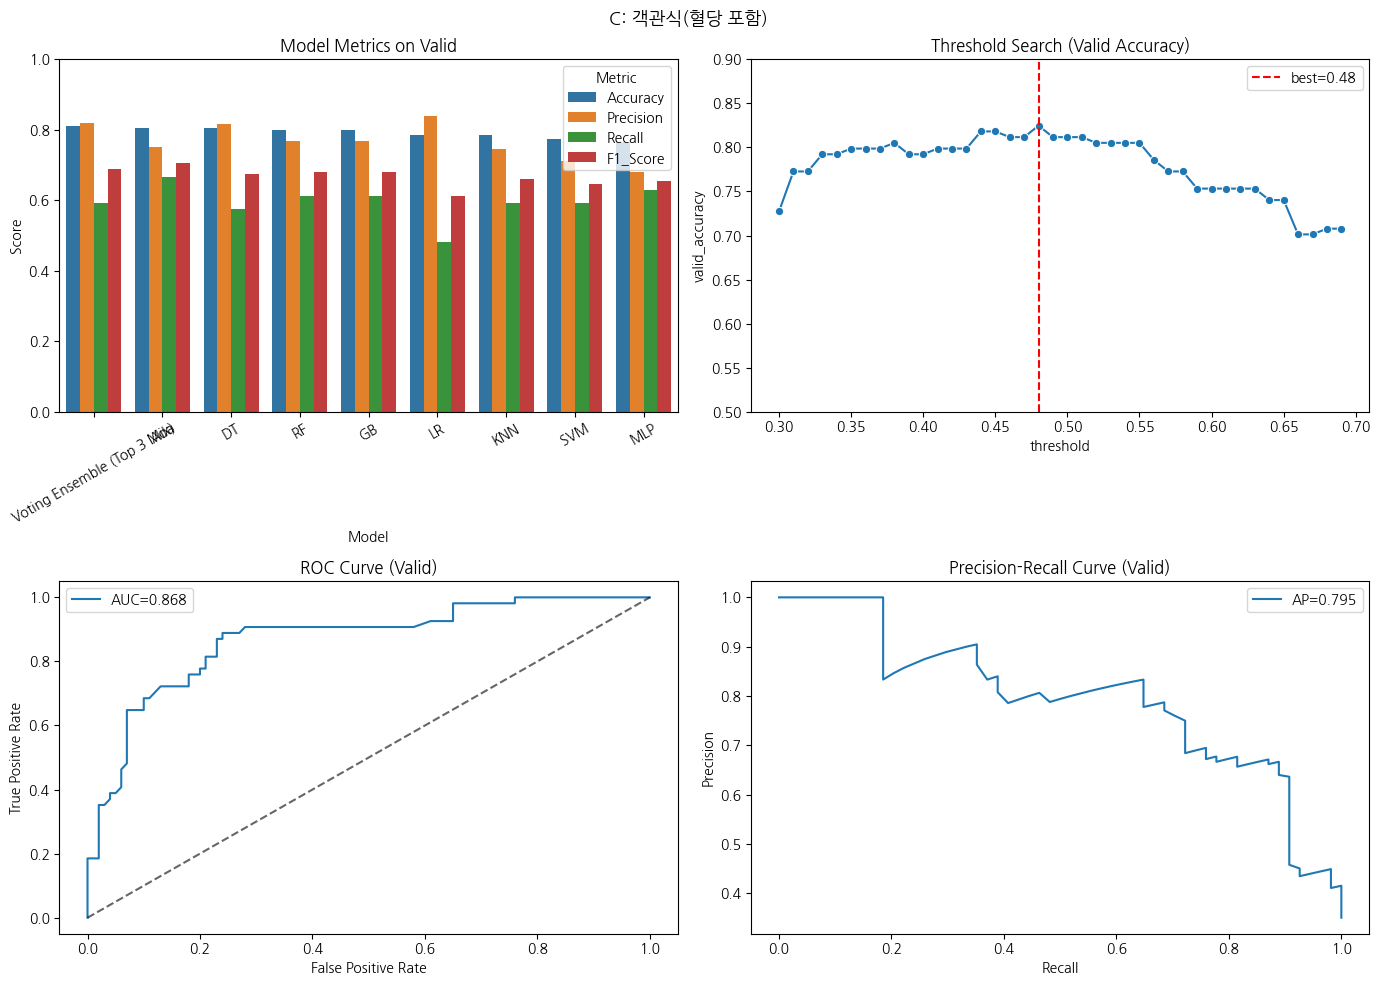

,Model,Accuracy,Precision,Recall,F1_Score,Valid Score(model.score)
0,Voting Ensemble (Top 3 Mix),0.8117,0.8205,0.5926,0.6882,0.8117
1,Ada,0.8052,0.7500,0.6667,0.7059,0.8052
2,DT,0.8052,0.8158,0.5741,0.6739,0.8052
3,RF,0.7987,0.7674,0.6111,0.6804,0.7987
4,GB,0.7987,0.7674,0.6111,0.6804,0.7987
5,LR,0.7857,0.8387,0.4815,0.6118,0.7857
6,KNN,0.7857,0.7442,0.5926,0.6598,0.7857
7,SVM,0.7727,0.7111,0.5926,0.6465,0.7662
8,MLP,0.7662,0.6800,0.6296,0.6538,0.7662



=== C-NS: 객관식(혈당 미포함) ===
Winner: Voting Ensemble (Top 3 Mix) | Best threshold: 0.38 | Best valid acc: 0.7468


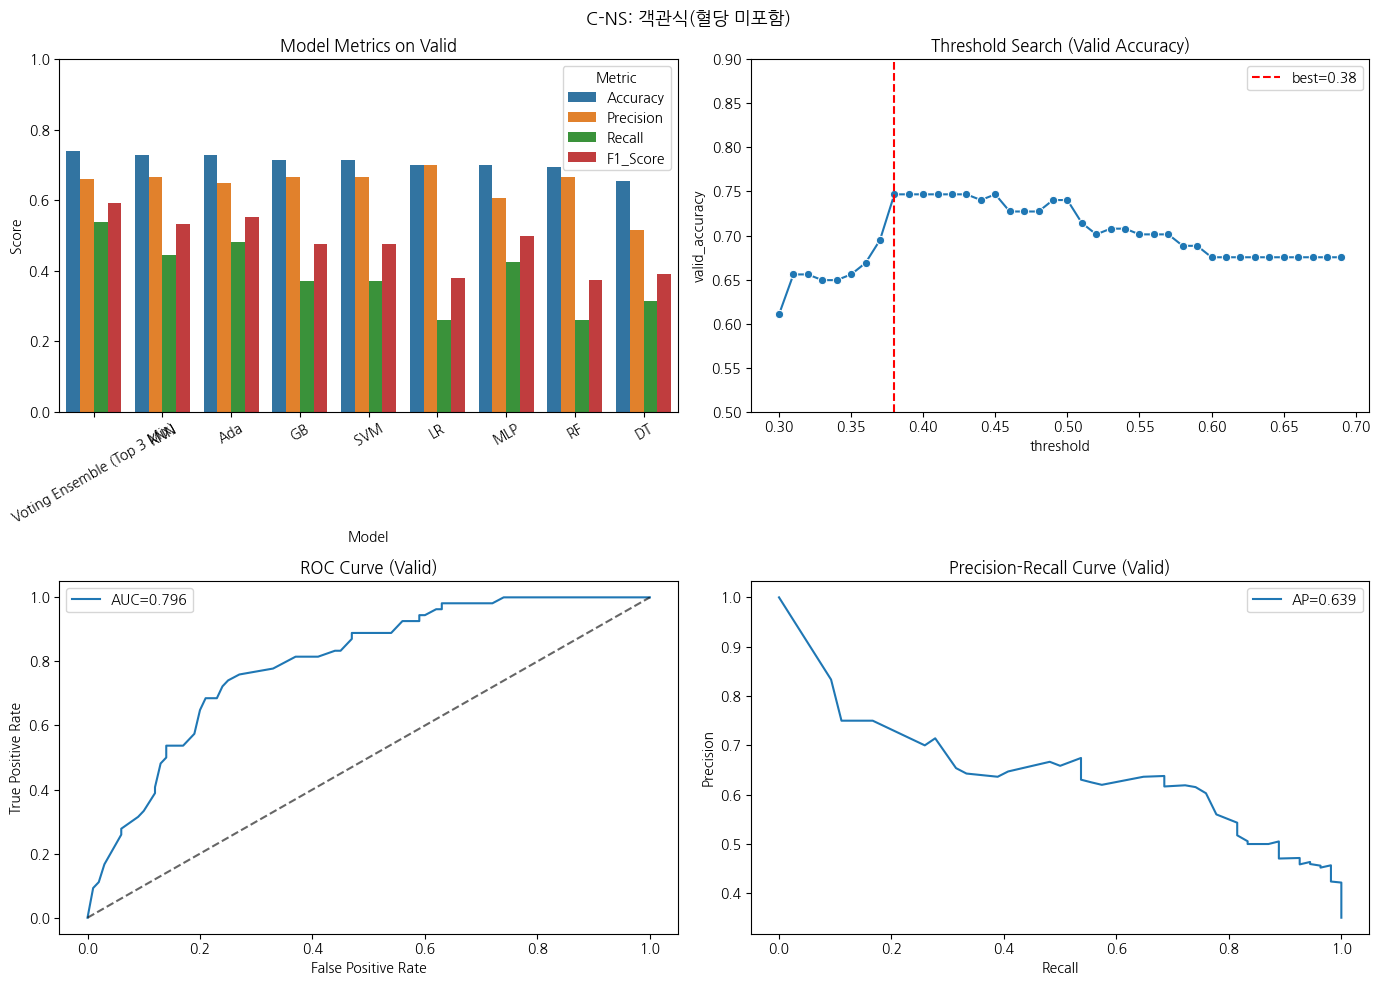

,Model,Accuracy,Precision,Recall,F1_Score,Valid Score(model.score)
0,Voting Ensemble (Top 3 Mix),0.7403,0.6591,0.5370,0.5918,0.7403
1,KNN,0.7273,0.6667,0.4444,0.5333,0.7273
2,Ada,0.7273,0.6500,0.4815,0.5532,0.7273
3,GB,0.7143,0.6667,0.3704,0.4762,0.7143
4,SVM,0.7143,0.6667,0.3704,0.4762,0.7143
5,LR,0.7013,0.7000,0.2593,0.3784,0.7013
6,MLP,0.7013,0.6053,0.4259,0.5000,0.7013
7,RF,0.6948,0.6667,0.2593,0.3733,0.6948
8,DT,0.6558,0.5152,0.3148,0.3908,0.6948


In [9]:
# 클래스 분포(전체)
fig, ax = plt.subplots(1, 1, figsize=(5, 3.5))
(y.value_counts().sort_index()).plot(kind='bar', ax=ax, color=['#4CAF50', '#E53935'])
ax.set_title('Overall Class Distribution (당뇨=0/1)')
ax.set_xlabel('Class')
ax.set_ylabel('Count')
for p in ax.patches:
    ax.annotate(f"{int(p.get_height())}", (p.get_x()+p.get_width()/2, p.get_height()),
                ha='center', va='bottom', fontsize=9)
plt.tight_layout()
plt.show()

# 시나리오별 추가 진단 그래프
scenario_defs = [
    (['임신횟수', '혈당', 'BMI', '나이'], 'A: 수치형(혈당 포함)', False),
    (['임신횟수', 'BMI', '나이'], 'B: 수치형(혈당 미포함)', False),
    (['임신횟수', '혈당', 'BMI', '나이'], 'C: 객관식(혈당 포함)', True),
    (['임신횟수', 'BMI', '나이'], 'C-NS: 객관식(혈당 미포함)', True),
]

ext_logs = [collect_extended_logs(*s) for s in scenario_defs]

for item in ext_logs:
    print(f"\n=== {item['scenario']} ===")
    print(f"Winner: {item['winner']} | Best threshold: {item['best_th']:.2f} | Best valid acc: {item['best_acc']:.4f}")

    # 2x2 diagnostics plot
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))

    # (1) 모델별 성능(Accuracy/Precision/Recall/F1)
    perf_melt = item['perf_df'][['Model', 'Accuracy', 'Precision', 'Recall', 'F1_Score']].melt(
        id_vars='Model', var_name='Metric', value_name='Score'
    )
    order = item['perf_df'].sort_values('Accuracy', ascending=False)['Model']
    sns.barplot(data=perf_melt, x='Model', y='Score', hue='Metric', order=order, ax=axes[0, 0])
    axes[0, 0].set_title('Model Metrics on Valid')
    axes[0, 0].tick_params(axis='x', rotation=30)
    axes[0, 0].set_ylim(0, 1)

    # (2) Threshold 탐색
    sns.lineplot(data=item['th_df'], x='threshold', y='valid_accuracy', marker='o', ax=axes[0, 1])
    axes[0, 1].axvline(item['best_th'], color='red', linestyle='--', label=f"best={item['best_th']:.2f}")
    axes[0, 1].set_title('Threshold Search (Valid Accuracy)')
    axes[0, 1].set_ylim(0.5, 0.9)
    axes[0, 1].legend()

    # (3) ROC
    axes[1, 0].plot(item['fpr'], item['tpr'], label=f"AUC={item['roc_auc']:.3f}")
    axes[1, 0].plot([0, 1], [0, 1], 'k--', alpha=0.6)
    axes[1, 0].set_title('ROC Curve (Valid)')
    axes[1, 0].set_xlabel('False Positive Rate')
    axes[1, 0].set_ylabel('True Positive Rate')
    axes[1, 0].legend()

    # (4) PR
    axes[1, 1].plot(item['pr_recall'], item['pr_precision'], label=f"AP={item['ap']:.3f}")
    axes[1, 1].set_title('Precision-Recall Curve (Valid)')
    axes[1, 1].set_xlabel('Recall')
    axes[1, 1].set_ylabel('Precision')
    axes[1, 1].legend()

    plt.suptitle(item['scenario'], fontsize=13)
    plt.tight_layout()
    plt.show()

    display(item['perf_df'].round(4))

### Candidate Confusion Matrices (Valid)

탐색 단계에서 각 시나리오의 **상위 3개 모델 + 최종 winner**에 대해
Validation confusion matrix를 비교합니다.

In [10]:
def collect_candidate_cm_logs(features, scenario_name, is_categorical=False):
    X = df[features].copy()

    X_temp, X_test, y_temp, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=42
    )
    X_train, X_valid, y_train, y_valid = train_test_split(
        X_temp, y_temp, test_size=0.25, stratify=y_temp, random_state=42
    )

    X_train_pre, X_valid_pre, _ = preprocess_like_final_cell(
        X_train.copy(), X_valid.copy(), X_test.copy(), is_categorical=is_categorical
    )

    candidate_models = [
        ('LR', LogisticRegression(C=0.01, random_state=42, max_iter=1000)),
        ('KNN', KNeighborsClassifier(n_neighbors=15)),
        ('RF', RandomForestClassifier(n_estimators=100, max_depth=3, random_state=42)),
        ('GB', GradientBoostingClassifier(n_estimators=30, max_depth=2, random_state=42)),
        ('Ada', AdaBoostClassifier(n_estimators=100, learning_rate=0.1, random_state=42)),
        ('SVM', SVC(C=1, probability=True, random_state=42)),
        ('MLP', MLPClassifier(hidden_layer_sizes=(50,), max_iter=1000, random_state=42)),
        ('DT', DecisionTreeClassifier(max_depth=3, random_state=42)),
    ]

    perf = []
    fitted = {}
    for name, model in candidate_models:
        model.fit(X_train_pre, y_train)
        score = model.score(X_valid_pre, y_valid)
        perf.append({'name': name, 'score': score})
        fitted[name] = model

    perf_df = pd.DataFrame(perf).sort_values('score', ascending=False).reset_index(drop=True)

    top3 = perf_df.head(3)['name'].tolist()
    ensemble = VotingClassifier(
        estimators=[(n, fitted[n]) for n in top3],
        voting='soft',
    )
    ensemble.fit(X_train_pre, y_train)
    ens_score = ensemble.score(X_valid_pre, y_valid)

    perf_df = pd.concat(
        [perf_df, pd.DataFrame([{'name': 'Voting Ensemble (Top 3 Mix)', 'score': ens_score}])],
        ignore_index=True,
    ).sort_values('score', ascending=False).reset_index(drop=True)

    winner_name = perf_df.iloc[0]['name']
    winner_model = ensemble if winner_name == 'Voting Ensemble (Top 3 Mix)' else fitted[winner_name]

    # winner threshold 탐색 (최종 로직 동일)
    valid_probs = winner_model.predict_proba(X_valid_pre)[:, 1]
    best_th, best_acc = 0.5, -1.0
    for th in np.arange(0.30, 0.70, 0.01):
        pred = (valid_probs >= th).astype(int)
        acc = accuracy_score(y_valid, pred)
        if acc > best_acc:
            best_acc = acc
            best_th = float(th)

    # 표시 대상: top3 + winner (중복 제거)
    display_names = top3.copy()
    if winner_name not in display_names:
        display_names.append(winner_name)

    cm_rows = []
    for name in display_names:
        model = ensemble if name == 'Voting Ensemble (Top 3 Mix)' else fitted[name]
        probs = model.predict_proba(X_valid_pre)[:, 1]
        # winner는 best_th, 나머지는 0.5로 비교
        threshold = best_th if name == winner_name else 0.5
        preds = (probs >= threshold).astype(int)
        cm = confusion_matrix(y_valid, preds)
        cm_rows.append({
            'name': name,
            'cm': cm,
            'acc': accuracy_score(y_valid, preds),
            'f1': f1_score(y_valid, preds, zero_division=0),
            'threshold': threshold,
            'is_winner': name == winner_name,
        })

    return {
        'scenario': scenario_name,
        'winner': winner_name,
        'best_th': best_th,
        'rows': cm_rows,
        'perf_df': perf_df,
    }


=== A: 수치형(혈당 포함) ===
Winner: LR | Winner best threshold: 0.50


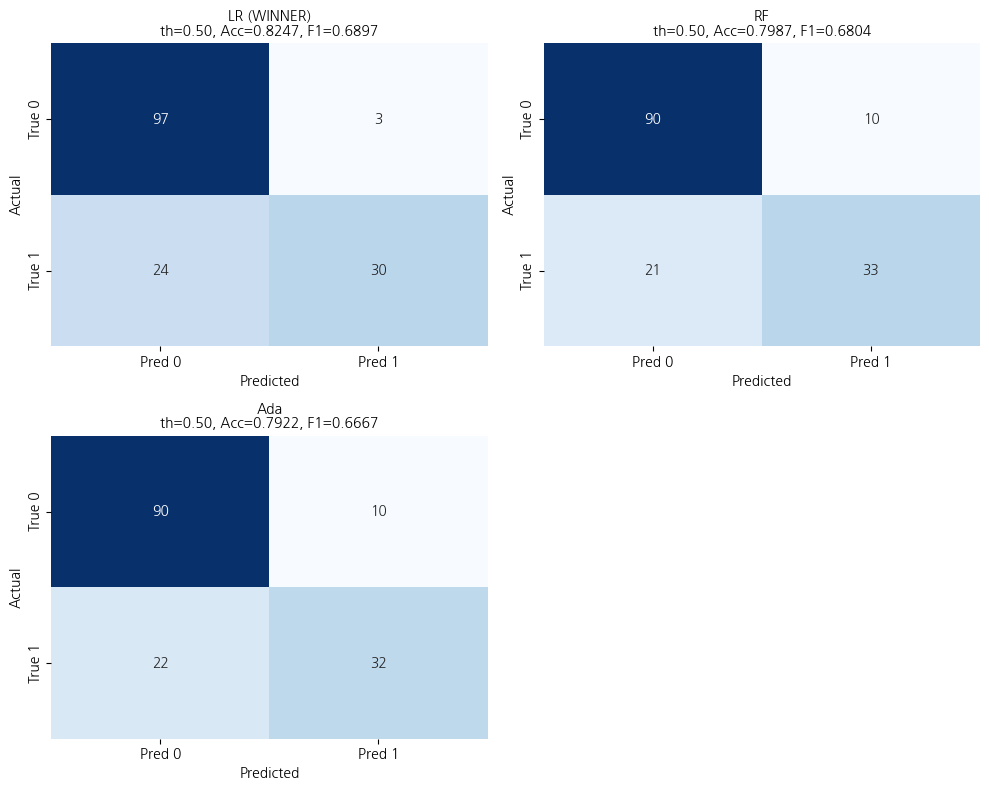

,Model,Valid Accuracy
0,LR,0.8247
1,Voting Ensemble (Top 3 Mix),0.8052
2,RF,0.7987
3,Ada,0.7922
4,GB,0.7857
5,DT,0.7857
6,SVM,0.7792
7,MLP,0.7727
8,KNN,0.7662



=== B: 수치형(혈당 미포함) ===
Winner: SVM | Winner best threshold: 0.36


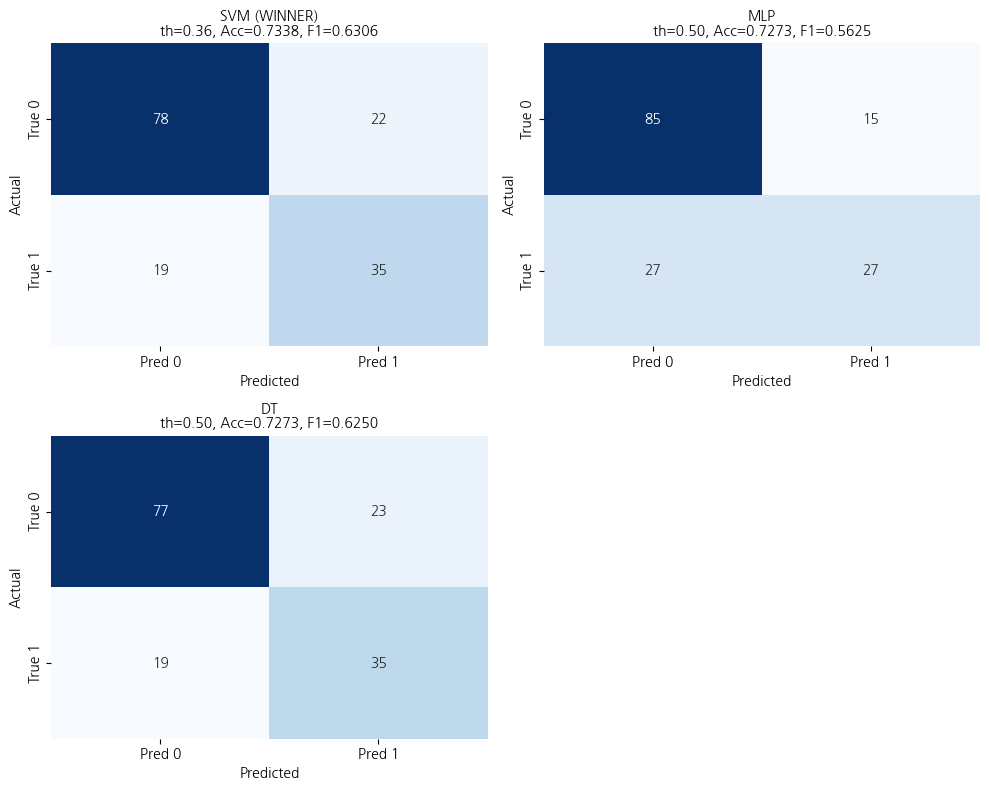

,Model,Valid Accuracy
0,SVM,0.7273
1,MLP,0.7273
2,DT,0.7273
3,KNN,0.7143
4,RF,0.7143
5,LR,0.7013
6,GB,0.7013
7,Voting Ensemble (Top 3 Mix),0.6948
8,Ada,0.6364



=== C: 객관식(혈당 포함) ===
Winner: Voting Ensemble (Top 3 Mix) | Winner best threshold: 0.48


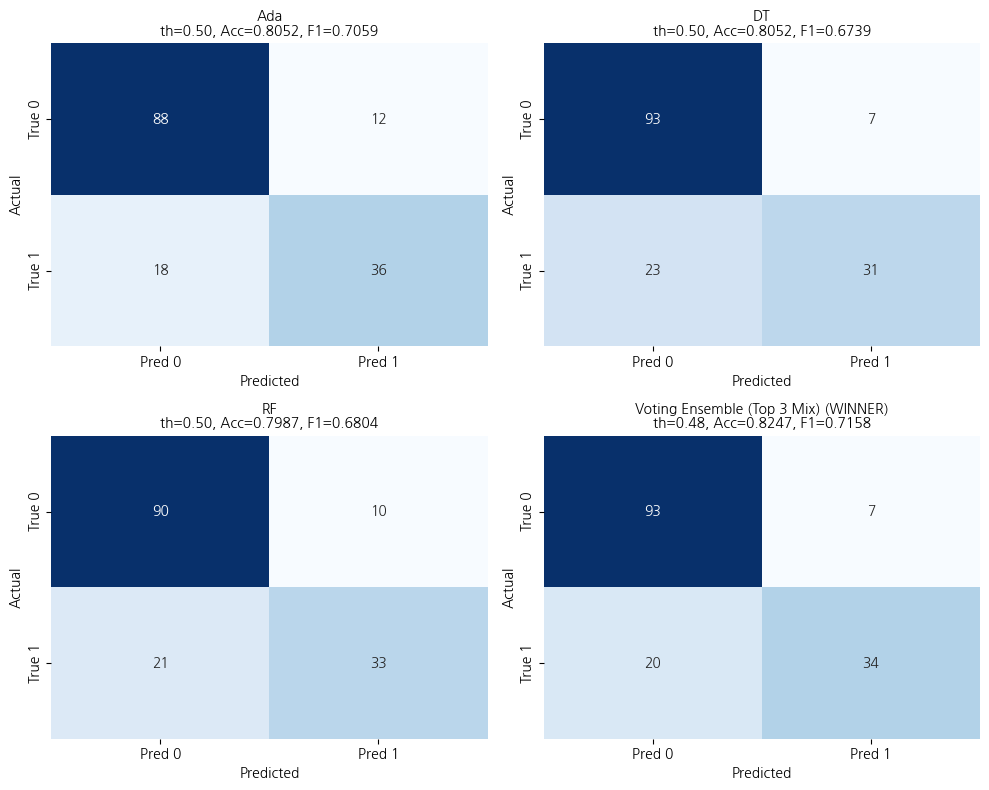

,Model,Valid Accuracy
0,Voting Ensemble (Top 3 Mix),0.8117
1,Ada,0.8052
2,DT,0.8052
3,RF,0.7987
4,GB,0.7987
5,LR,0.7857
6,KNN,0.7857
7,SVM,0.7662
8,MLP,0.7662



=== C-NS: 객관식(혈당 미포함) ===
Winner: Voting Ensemble (Top 3 Mix) | Winner best threshold: 0.38


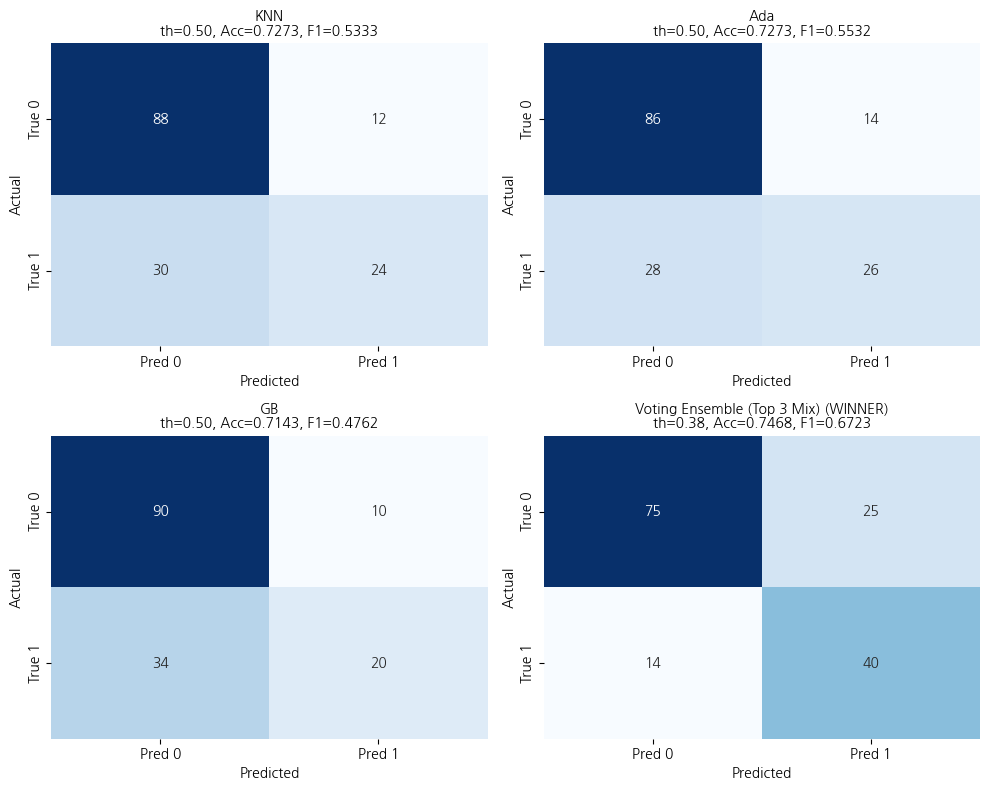

,Model,Valid Accuracy
0,Voting Ensemble (Top 3 Mix),0.7403
1,KNN,0.7273
2,Ada,0.7273
3,GB,0.7143
4,SVM,0.7143
5,LR,0.7013
6,MLP,0.7013
7,RF,0.6948
8,DT,0.6948


In [11]:
candidate_cm_logs = [
    collect_candidate_cm_logs(['임신횟수', '혈당', 'BMI', '나이'], 'A: 수치형(혈당 포함)', False),
    collect_candidate_cm_logs(['임신횟수', 'BMI', '나이'], 'B: 수치형(혈당 미포함)', False),
    collect_candidate_cm_logs(['임신횟수', '혈당', 'BMI', '나이'], 'C: 객관식(혈당 포함)', True),
    collect_candidate_cm_logs(['임신횟수', 'BMI', '나이'], 'C-NS: 객관식(혈당 미포함)', True),
]

for log in candidate_cm_logs:
    print(f"\n=== {log['scenario']} ===")
    print(f"Winner: {log['winner']} | Winner best threshold: {log['best_th']:.2f}")

    n = len(log['rows'])
    cols = 2
    rows = int(np.ceil(n / cols))
    fig, axes = plt.subplots(rows, cols, figsize=(10, 4 * rows))
    axes = np.array(axes).reshape(-1)

    for i, row in enumerate(log['rows']):
        ax = axes[i]
        sns.heatmap(
            row['cm'],
            annot=True,
            fmt='d',
            cmap='Blues',
            cbar=False,
            ax=ax,
            xticklabels=['Pred 0', 'Pred 1'],
            yticklabels=['True 0', 'True 1'],
        )
        winner_tag = ' (WINNER)' if row['is_winner'] else ''
        ax.set_title(
            f"{row['name']}{winner_tag}\n"
            f"th={row['threshold']:.2f}, Acc={row['acc']:.4f}, F1={row['f1']:.4f}",
            fontsize=10,
        )
        ax.set_xlabel('Predicted')
        ax.set_ylabel('Actual')

    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

    display(
        log['perf_df']
        .rename(columns={'name': 'Model', 'score': 'Valid Accuracy'})
        .round(4)
    )